# extraction données 

In [3]:

from datetime import datetime, timedelta
import pandas as pd
import backtrader as bt



full_df = pd.read_csv('us_banks.csv')

# Étape 1 : conversion explicite en datetime (si ce n'est pas déjà le cas)
full_df['date'] = pd.to_datetime(full_df['date'], errors='coerce')
# Étape 2 : enlever le fuseau horaire SANS conversion d'heure
# (on enlève tzinfo mais on garde l'heure locale telle quelle)
full_df['date'] = full_df['date'].apply(lambda dt: dt.replace(tzinfo=None) if pd.notna(dt) else dt)


# Étape 2: sélectionner les colonnes d'intérêt
cols = ['date', 'symbol', 'open', 'high', 'low', 'close', 'volume']
full_df = full_df[cols]

# Étape 3: pivot en colonnes multiples
df_wide = full_df.pivot(index='date', columns='symbol', values=['open', 'high', 'low', 'close', 'volume'])

# Étape 4: réordonner les colonnes si tu veux (facultatif)
df_wide = df_wide.reorder_levels([1, 0], axis=1).sort_index(axis=1)

# Étape 5: fixer l'index datetime
df_wide.index = pd.to_datetime(df_wide.index)




# ------------------------------------------------------------------
# 2) Fonctions utilitaires (identiques, mais génériques)
# ------------------------------------------------------------------
def prepare_for_backtrader(df_wide, symbol):
    """
    Extrait le sous-DataFrame df_wide[symbol] (colonnes OHLCV)
    et ajoute openinterest = 0 pour Backtrader.
    """
    df = df_wide[symbol].copy()
    required = ['open', 'high', 'low', 'close', 'volume']
    if not all(col in df.columns for col in required):
        missing = [c for c in required if c not in df.columns]
        raise ValueError(f"{symbol} – colonnes manquantes : {missing}")
    df['openinterest'] = 0
    df = df.dropna()
    return df[['open', 'high', 'low', 'close', 'volume', 'openinterest']]

def filter_last_days(df, n_days):
    cutoff = df.index.max() - timedelta(days=n_days)
    return df[df.index >= cutoff]


# Backtest

In [4]:
def prepare_for_backtrader(df_wide, symbol):
    """
    Extrait le sous-DataFrame df_wide[symbol] (colonnes OHLCV)
    et ajoute openinterest = 0 pour Backtrader.
    """
    df = df_wide[symbol].copy()
    required = ['open', 'high', 'low', 'close', 'volume']
    if not all(col in df.columns for col in required):
        missing = [c for c in required if c not in df.columns]
        raise ValueError(f"{symbol} – colonnes manquantes : {missing}")
    df['openinterest'] = 0
    #df = df.dropna()
    return df[['open', 'high', 'low', 'close', 'volume', 'openinterest']]

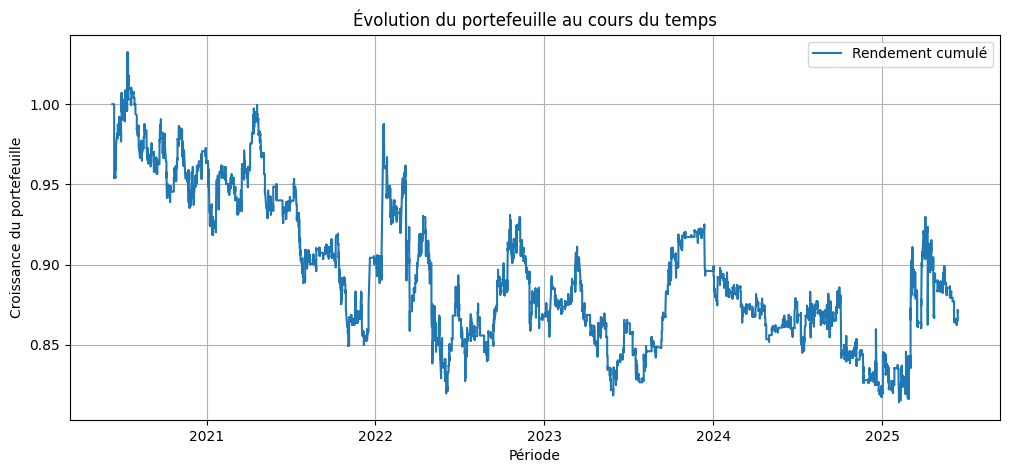

Volatilité annualisée : 0.1369
Sharpe ratio : -0.1718
Drawdown maximal : -0.2113

Fréquence des paires sélectionnées :
(MS, GS)    1251
Name: count, dtype: int64

Nombre moyen de trades par jour : 0.78
Gain moyen : 351.9501
Perte moyenne : -350.6910
Durée moyenne des positions (h) : 0.88


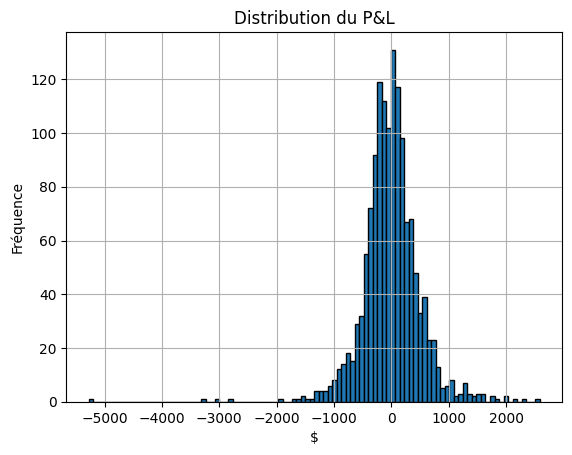

In [14]:
from backtest import PairTradingStrategy
from dependence_modeling import *


"""
symbols = ['JPM', 'BAC', 'C', 'WFC', 'USB',
           'PNC', 'TFC', 'GS', 'MS', 'SCHW']
"""
"""
symbols = ['JPM', 'BAC', 'C', 'WFC',
           'GS', 'MS']
"""

symbols = ['MS', 'GS']

# ------------------------------------------------------------------
# 3) Construction du moteur Backtrader
# ------------------------------------------------------------------
cerebro = bt.Cerebro()

# a) ajouter chaque flux de données
for sym in symbols:
    data = prepare_for_backtrader(df_wide, sym)
    # ↓ optionnel – filtrer les 250 derniers jours, par ex.
    #data = filter_last_days(data, 250)
    feed = bt.feeds.PandasData(dataname=data, name=sym)
    cerebro.adddata(feed, name=sym)

# b) paramètre pour la stratégie
params_config = dict(
    stocks=symbols,
    training_day=1,
    trading_day=1,
    trade_condition=0.99,
    statistical_model=CopuleGarch,
    profit_target=0.0015,
    edge_buffer=6
)

cerebro.addstrategy(PairTradingStrategy, **params_config)


# ------------------------------------------------------------------
# 4) Paramètres broker et lancement
# ------------------------------------------------------------------
cerebro.broker.setcash(100000)
cerebro.broker.setcommission(leverage=1.01)
cerebro.broker.setcommission(commission=0.00005)  # 0.005%




results = cerebro.run()

# Ajout backtest de portefeuille de plusieurs strat! apres ca va juste a me rester a construire portfolio !

In [122]:
from backtest2 import PortfolioBacktest
from dependence_modeling import *

symbols = ['JPM', 'BAC', 'C', 'WFC', 'USB',
           'PNC', 'TFC', 'GS', 'MS', 'SCHW']

params_config = dict(
    training_day=1,
    trading_day=1,
    trade_condition=0.99,
    statistical_model=CopuleGarch,
    profit_target=0.0015,
    edge_buffer=6
    )



backtest = PortfolioBacktest(
    stocks=symbols,
    df=df_wide,
    fees=0.0005,
    params=params_config,
    nom_fichier_result='resultat_wfees'
)


backtest.run() 
    

Backtesting pairs: 100%|██████████| 45/45 [4:53:51<00:00, 391.81s/it]  


JPM                                              \
                              BAC              C            WFC           USB   
2020-06-11 10:00:00  100000.00000  100000.000000  100000.000000  100000.00000   
2020-06-11 10:05:00  100000.00000  100000.000000  100000.000000  100000.00000   
2020-06-11 10:10:00  100000.00000  100000.000000  100000.000000  100000.00000   
2020-06-11 10:15:00  100000.00000  100000.000000  100000.000000  100000.00000   
2020-06-11 10:20:00  100000.00000  100000.000000  100000.000000  100000.00000   
...                           ...            ...            ...           ...   
2025-06-13 15:10:00     967.05582  -25467.128715    2209.695055   42182.30742   
2025-06-13 15:15:00    1034.91582  -24989.098715    2209.695055   42182.30742   
2025-06-13 15:20:00    1034.91582  -24511.068715    2209.695055   42182.30742   
2025-06-13 15:25:00    1125.39582  -23896.458715    2209.695055   42182.30742   
2025-06-13 15:55:00    1012.29582            NaN            NaN           NaN   

                                                                               \
                               PNC            TFC            GS            MS   
2020-06-11 10:00:00  100000.000000  100000.000000  100000.00000  100000.00000   
2020-06-11 10:05:00  100000.000000  100000.000000  100000.00000  100000.00000   
2020-06-11 10:10:00  100000.000000  100000.000000  100000.00000  100000.00000   
2020-06-11 10:15:00  100000.000000  100000.000000  100000.00000  100000.00000   
2020-06-11 10:20:00  100000.000000  100000.000000  100000.00000  100000.00000   
...                            ...            ...           ...           ...   
2025-06-13 15:10:00 -141775.934555   30975.493435  127508.00896  -63654.79553   
2025-06-13 15:15:00 -141294.664555   30975.493435  127508.00896  -63357.07553   
2025-06-13 15:20:00 -140926.634555   30975.493435  127508.00896  -62563.15553   
2025-06-13 15:25:00 -140162.264555   30975.493435  127508.00896  -61918.09553   
2025-06-13 15:55:00            NaN            NaN           NaN           NaN   

                                              BAC  ...       PNC            \
                              SCHW              C  ...       TFC        GS   
2020-06-11 10:00:00  100000.000000  100000.000000  ...  100000.0  100000.0   
2020-06-11 10:05:00  100000.000000  100000.000000  ...  100000.0  100000.0   
2020-06-11 10:10:00  100000.000000  100000.000000  ...  100000.0  100000.0   
2020-06-11 10:15:00  100000.000000  100000.000000  ...  100000.0  100000.0   
2020-06-11 10:20:00  100000.000000  100000.000000  ...  100000.0  100000.0   
...                            ...            ...  ...       ...       ...   
2025-06-13 15:10:00    2238.902785   -1393.614875  ...       NaN       NaN   
2025-06-13 15:15:00    2238.902785   -1393.614875  ...       NaN       NaN   
2025-06-13 15:20:00    2238.902785   -1393.614875  ...       NaN       NaN   
2025-06-13 15:25:00    2238.902785   -1393.614875  ...       NaN       NaN   
2025-06-13 15:55:00            NaN            NaN  ...       NaN       NaN   

                                                           TFC                 \
                                MS          SCHW            GS             MS   
2020-06-11 10:00:00  100000.000000  100000.00000  100000.00000  100000.000000   
2020-06-11 10:05:00  100000.000000  100000.00000  100000.00000  100000.000000   
2020-06-11 10:10:00  100000.000000  100000.00000  100000.00000  100000.000000   
2020-06-11 10:15:00  100000.000000  100000.00000  100000.00000  100000.000000   
2020-06-11 10:20:00  100000.000000  100000.00000  100000.00000  100000.000000   
...                            ...           ...           ...            ...   
2025-06-13 15:10:00  -18687.928905   -7378.34021  230283.11259   -1680.699125   
2025-06-13 15:15:00  -18540.928905   -7378.34021  230283.11259   -1680.699125   
2025-06-13 15:20:00  -18148.928905   -7378.34021  230283.11259   -1680.699125   
2025-06-13 15:25

# affichage résultat des pairs!

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import math


def print_trades(path):
    # Charger le DataFrame contenant les equity curves
    df = pd.read_pickle(path)  # adapte le nom si besoin

    # Paramètres d’affichage
    n_pairs = df.shape[1]
    n_cols = 3
    n_rows = math.ceil(n_pairs / n_cols)

    # Taille globale de la figure
    plt.figure(figsize=(5 * n_cols, 4 * n_rows))

    # Tracer chaque equity curve
    for i, pair in enumerate(df.columns):
        plt.subplot(n_rows, n_cols, i + 1)
        rendement_cumule = df[pair] / df[pair].iloc[0] - 1
        rendement_cumule.plot()
        plt.title(f"{pair[0]} / {pair[1]}")
        plt.xlabel("Date")
        plt.ylabel("Equity")
        plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Résumé statistique
    summary = pd.DataFrame(index=df.columns)
    summary["Final Value"] = df.apply(lambda s: s.iloc[-1])
    summary["Return (%)"] = df.apply(lambda s: 100 * (s.iloc[-1] - s.iloc[0]) / s.iloc[0])
    summary["Max Drawdown"] = df.apply(lambda s: (s.cummax() - s).max())

    print("\nRésumé des performances :")
    print(summary.round(2))




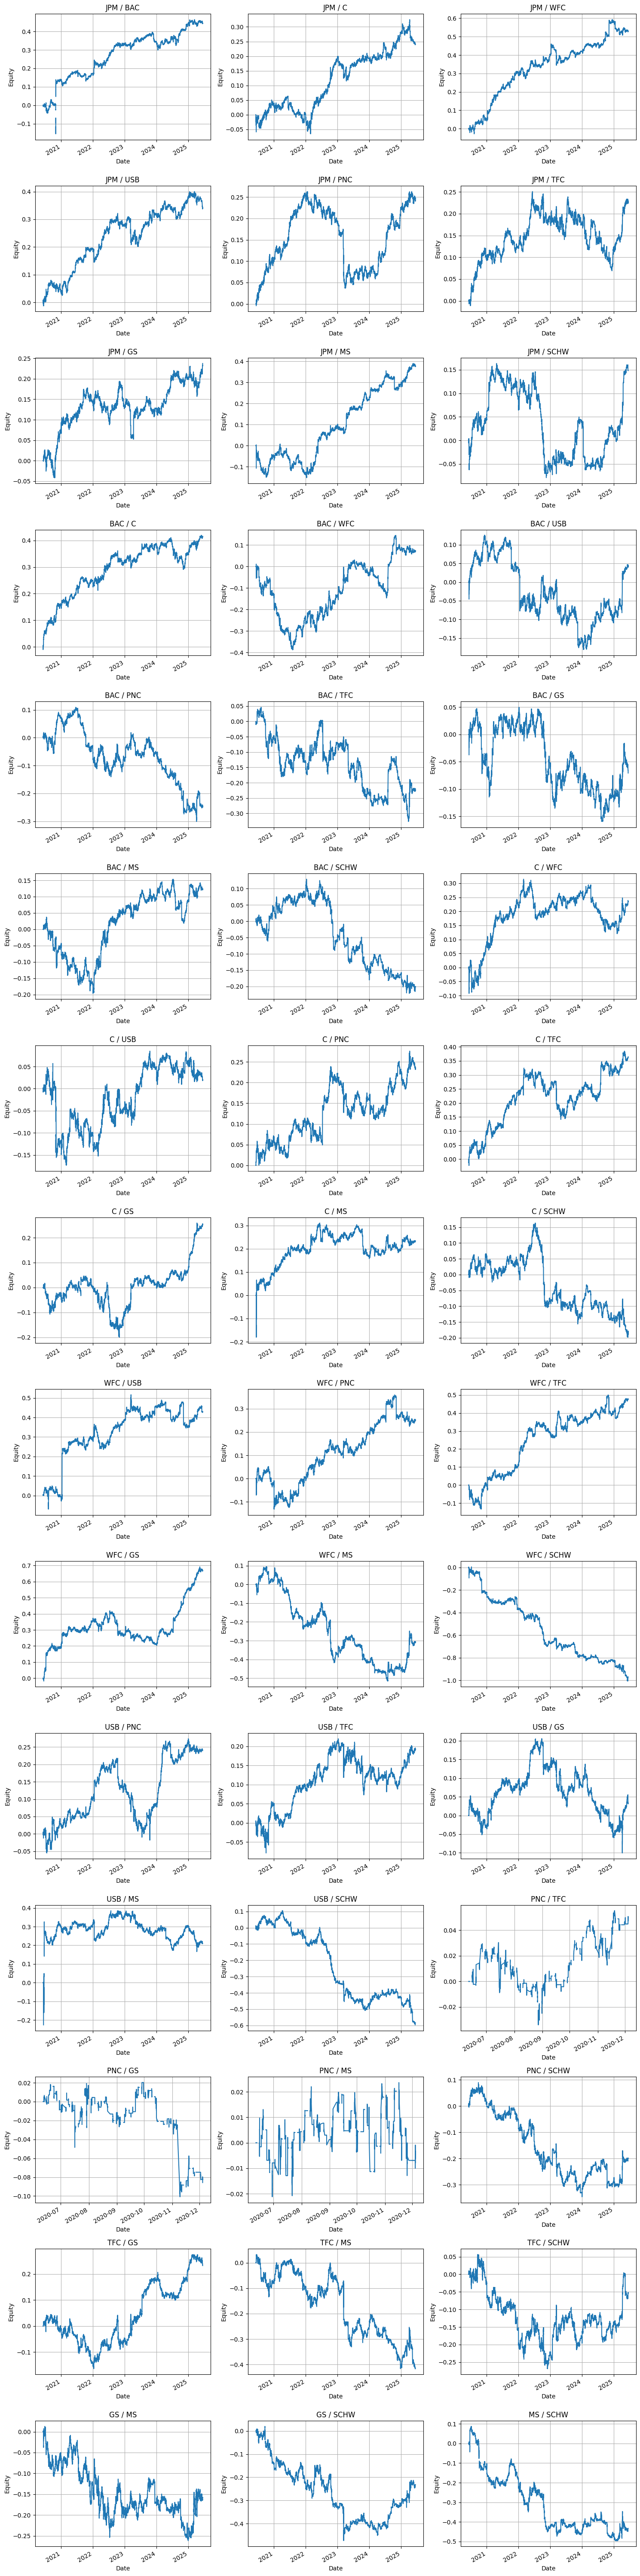


Résumé des performances :
          Final Value  Return (%)  Max Drawdown
JPM BAC     144500.47       44.50      18579.66
    C             NaN         NaN      12897.26
    WFC           NaN         NaN      11527.52
    USB           NaN         NaN      11960.03
    PNC           NaN         NaN      22600.28
    TFC           NaN         NaN      18197.46
    GS            NaN         NaN      14194.69
    MS            NaN         NaN      15992.47
    SCHW          NaN         NaN      24232.91
BAC C             NaN         NaN      11858.90
    WFC           NaN         NaN      39773.16
    USB           NaN         NaN      30602.03
    PNC           NaN         NaN      41067.98
    TFC           NaN         NaN      37255.31
    GS            NaN         NaN      20914.52
    MS            NaN         NaN      23356.92
    SCHW          NaN         NaN      35055.49
C   WFC           NaN         NaN      19323.69
    USB           NaN         NaN      22989.50
    PNC      

In [22]:
print_trades('resultat.pkl')

In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

class DynamicPairPortfolio:
    def __init__(self, df_equity, window=22, top_n=3, sharpe_min=0, rebalance_freq=1):
        """
        Paramètres :
        - df_equity : DataFrame avec les equity curves (index = date, colonnes = paires)
        - window : nombre de jours pour la fenêtre de Sharpe ratio
        - top_n : nombre de paires à sélectionner
        - sharpe_min : Sharpe minimum requis
        - rebalance_freq : fréquence de rebalancement en jours
        """
        self.window = window
        self.top_n = top_n
        self.sharpe_min = sharpe_min
        self.rebalance_freq = rebalance_freq

        self.df_equity = df_equity.resample('1D').last().pct_change()

        # Pré-calcul des ratios de Sharpe glissants
        rolling_mean = self.df_equity.rolling(window=window).mean()
        rolling_std = self.df_equity.rolling(window=window).std()
        self.df_sharpe = (rolling_mean / rolling_std).shift(1)

        # Résultats à remplir après le backtest
        self.daily_returns = None
        self.cumulative_returns = None
        self.weights_history = []


        #éxécution du code 
        self.run_backtest()
        self.plot_cumulative_returns()
        self.print_performance()

    def _select_top_pairs(self, date):
        """
        Sélectionne les meilleures paires selon le Sharpe ratio pré-calculé à la date donnée.
        """
        if date not in self.df_sharpe.index:
            print("WTF!!")
            return [], pd.Series()

        sharpe_today = self.df_sharpe.loc[date]
        sharpe_today = sharpe_today[sharpe_today > self.sharpe_min]
        top_pairs = sharpe_today.sort_values(ascending=False).head(self.top_n)
        
        
        if len(top_pairs) > 0:
            weights = pd.Series(1 / len(top_pairs), index=top_pairs.index)
        else:
            weights = pd.Series()
        
        return top_pairs.index, weights

    def run_backtest(self):
        """
        Lance le backtest dynamique en sélectionnant les meilleures paires
        à chaque date de rebalancement et en calculant les rendements du portefeuille.
        """
        dates = self.df_sharpe.index[self.window:]
        returns_list = []
        current_weights = pd.Series(dtype=float)

        for i, date in enumerate(dates):
            if i % self.rebalance_freq == 0:
                selected_pairs, current_weights = self._select_top_pairs(date)
                self.weights_history.append((date, current_weights))

            if len(current_weights) == 0:
                returns_list.append(0)
                continue

            rets_today = self.df_equity.loc[date, current_weights.index]
            portfolio_return = rets_today.dot(current_weights)
            returns_list.append(portfolio_return)

        self.daily_returns = pd.Series(returns_list, index=dates)
        self.cumulative_returns = (1 + self.daily_returns).cumprod() 
        return self.cumulative_returns

    def plot_cumulative_returns(self):
        """
        Trace le rendement cumulé du portefeuille.
        """
        if self.cumulative_returns is None:
            raise ValueError("Backtest not run yet.")
        plt.figure(figsize=(10, 5))
        self.cumulative_returns.plot()
        plt.title("Rendement cumulé du portefeuille dynamique")
        plt.ylabel("Rendement cumulé")
        plt.xlabel("Date")
        plt.grid(True)
        plt.show()

    def print_performance(self):
        """
        Affiche les statistiques de performance du portefeuille.
        """
        if self.daily_returns is None:
            raise ValueError("Backtest not run yet.")
        total_return = self.cumulative_returns.iloc[-1] -1
        volatility = self.daily_returns.std() * np.sqrt(252)
        sharpe = self.daily_returns.mean() / self.daily_returns.std() * np.sqrt(252)
        max_drawdown = (self.cumulative_returns.cummax() - self.cumulative_returns).max()

        print("\n📊 Statistiques de performance du portefeuille stat-arb :")
        print(f"Total Return       : {total_return * 100:.2f} %")
        print(f"Annual Volatility  : {volatility * 100:.2f} %")
        print(f"Sharpe Ratio       : {sharpe:.2f}")
        print(f"Max Drawdown       : {max_drawdown * 100:.2f} %")

    def get_weights_history(self):
        """
        Retourne la liste des pondérations appliquées à chaque date de rebalancement.
        """
        return self.weights_history


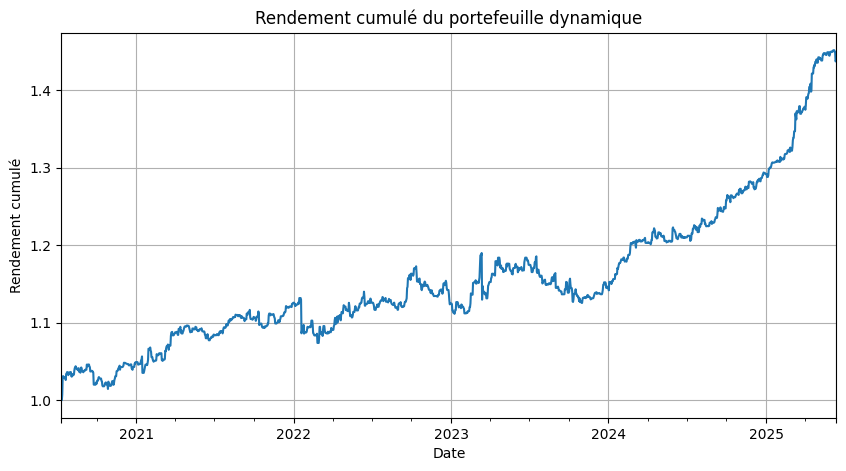


📊 Statistiques de performance du portefeuille stat-arb :
Total Return       : 43.86 %
Annual Volatility  : 5.01 %
Sharpe Ratio       : 1.04
Max Drawdown       : 6.44 %


In [121]:
# Charger tes résultats de paires
df_equity = pd.read_pickle("resultat.pkl")

# Créer et lancer le backtest
portfolio = DynamicPairPortfolio(df_equity, window=30, top_n=3, sharpe_min=0, rebalance_freq=1)
